<a href="https://colab.research.google.com/github/0x1beef/uap/blob/main/src/gimbal_adjust_clouds.ipynb">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
<a href="https://kaggle.com/kernels/welcome?src=https://github.com/0x1beef/uap/blob/main/src/gimbal_adjust_clouds.ipynb">
    <img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open In Kaggle"   />
</a>

In [1]:
url = 'https://raw.githubusercontent.com/0x1beef/uap/main/src'
import os, urllib.request
for py_file in ['utils.py','common.py']:
    if not os.path.exists(py_file):
        urllib.request.urlretrieve(f'{url}/{py_file}', py_file)
import utils, common

## **Get the data**

In [2]:
utils.download_from_huggingface('logicbear/gimbal/data/object_data.parquet')
utils.download_from_huggingface('logicbear/gimbal_cloud_means/data/cloud_means.parquet')

cloud_means.parquet:   0%|          | 0.00/1.19M [00:00<?, ?B/s]

In [3]:
(object_data, object_metadata) = utils.from_parquet_ext('data/object_data.parquet', 'gimbal')
(cloud_data, cloud_metadata) = utils.from_parquet_ext('data/cloud_means.parquet', 'clouds')

import numpy as np

def get_com(frame):
    od = object_data.loc[frame]
    return np.array([od.center_of_mass_x, od.center_of_mass_y]).T

def get_horizon(frame):
    return object_data.loc[frame].human_horizon

## **Adjust to account for background motion/rotation**

In [4]:
import math
from dataclasses import dataclass
from numba import njit

@dataclass
class AdjustedMotion:
    frame: int; frame_diff: int
    magnitude: float; angle: float; rotation: float
    adj_magnitude: float; adj_angle: float; adj_rotation: float

def adjust_cloud_motion(frame, frame_diff_func):
    frame_diff = frame_diff_func(frame)
    if frame + frame_diff >= len(object_data):
        return None
    cd = cloud_data.loc[frame, frame_diff]
    R = cd['transform'][0:2,0:2]
    scale = math.sqrt(R[0,0]*R[0,0] + R[0,1]*R[0,1])
    R = R / scale
    C = np.array([213,211]).T
    P1 = cd.c_inl_mean
    P2 = cd.cn_inl_mean
    Rinv = np.linalg.inv(R)
    O1 = get_com(frame)
    O2 = get_com(frame + frame_diff)
    V = Rinv @ (P2 - C) - P1 + C - (O2 - O1)
    magnitude = np.linalg.norm(V) / frame_diff
    angle = math.degrees(math.atan2(V[1], V[0]))
    rotation = cd.rotation + (get_horizon(frame + frame_diff) - get_horizon(frame))
    return AdjustedMotion(frame, frame_diff, cd.magnitude, cd.angle, cd.rotation,
        magnitude, angle, rotation)

def adjust_cloud_motion_for(frames, frame_diff_func):
    motions = [adjust_cloud_motion(frame, frame_diff_func) for frame in frames]
    return [m for m in motions if m is not None]
def run_adjust_cloud_motion(frame_diff_func):
    return adjust_cloud_motion_for(range(len(object_data)), frame_diff_func)
def run_adjust_cloud_motion_parallel(frame_diff_func):
    return utils.run_jobs_in_parallel(work_func = adjust_cloud_motion_for,
        work_args = (frame_diff_func), jobs = range(len(object_data)), workers = 4)

adjust_cloud_motion(0, lambda _: 5)

AdjustedMotion(frame=0, frame_diff=5, magnitude=6.492830080260229, angle=15.726787595199855, rotation=0.39422017371017143, adj_magnitude=6.523222728366252, adj_angle=16.544429220181495, adj_rotation=0.23849207472659822)

## **Plot the results**

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

def get_adj_motion_df(adj_motions, fps):
    df = pd.DataFrame.from_records([m.__dict__ for m in adj_motions], index = ["frame"])
    df = df.sort_index()
    df = common.gimbal_fix_wh_to_bh(df, ['magnitude','angle','rotation',
        'adj_magnitude','adj_angle','adj_rotation'], minus = df.frame_diff.max())
    df.attrs['fps'] = fps   # used to convert frame to time while plotting
    return df

def mag_plot(df, range):
    plt.title('cloud motion magnitude')
    plt.ylabel('pixels / frame')
    df.magnitude[range].plot(color='gray')
    df.adj_magnitude[range].plot(color='orange', label='mag adjusted')

def angle_plot(df, range):
    plt.title('cloud motion angle')
    plt.ylabel('degrees')
    df.angle[range].plot(color='gray')
    df.adj_angle[range].plot(color='orange', label='angle adjusted')
    plt.ylim(bottom=13, top=48)
    (-object_data.human_horizon)[range].plot()

def rot_plot(df, range):
    plt.title('cloud rotation')
    plt.ylabel('degrees')
    df.rotation[range].plot(color='gray')
    df.adj_rotation[range].plot(color='orange', label='rot adjusted')

def plot_all(df):
    plot = common.plot_frame_data
    plot(df, mag_plot, range(len(df)))
    plot(df, mag_plot, range(700, len(df)))
    plot(df, angle_plot, range(len(df)))
    plot(df, rot_plot, range(len(df)))
    plot(df, rot_plot, range(700, len(df)))

In [6]:
def run_and_plot_all(frame_diff_from, frame_diff_to):
    print(f'frame diff: {frame_diff_from} - {frame_diff_to}')
    num_frames = len(object_data)
    def get_frame_diff(frame):
        return common.get_frame_diff(frame, frame_diff_from, frame_diff_to, num_frames)
    adj_motions = %time run_adjust_cloud_motion(get_frame_diff)
    df = get_adj_motion_df(adj_motions, object_metadata['fps'])
    %time plot_all(df)

interactive(children=(IntSlider(value=6, description='diff from:', max=12, min=2), IntSlider(value=10, descrip…

frame diff: 6 - 10
CPU times: total: 672 ms
Wall time: 681 ms


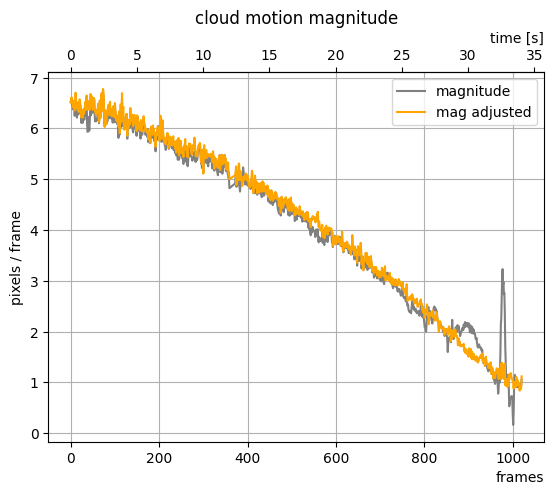

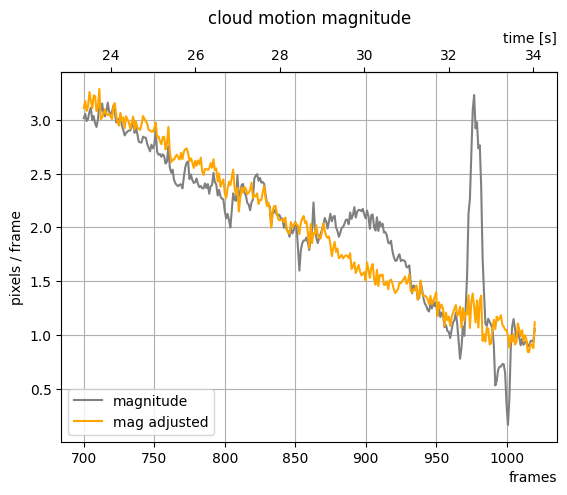

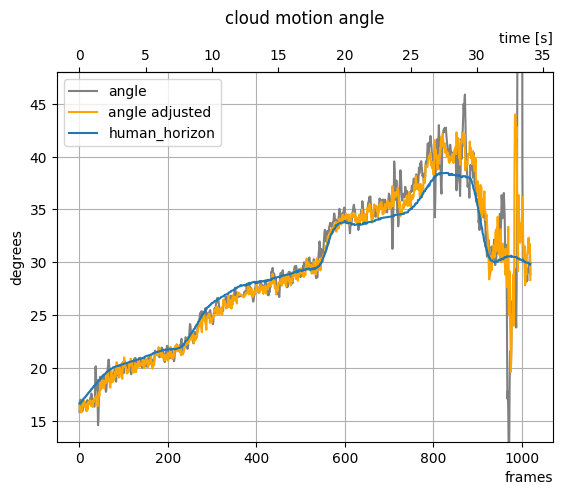

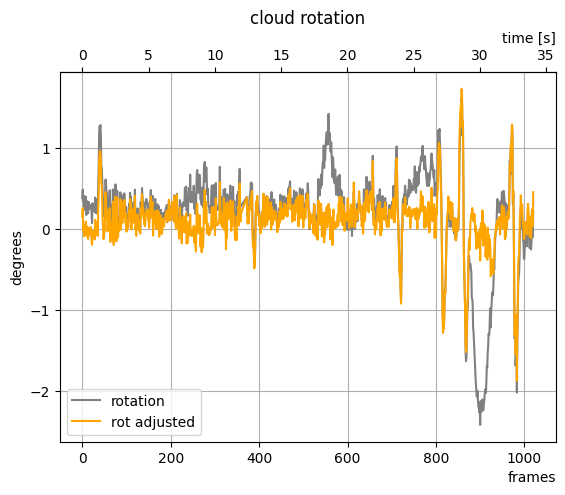

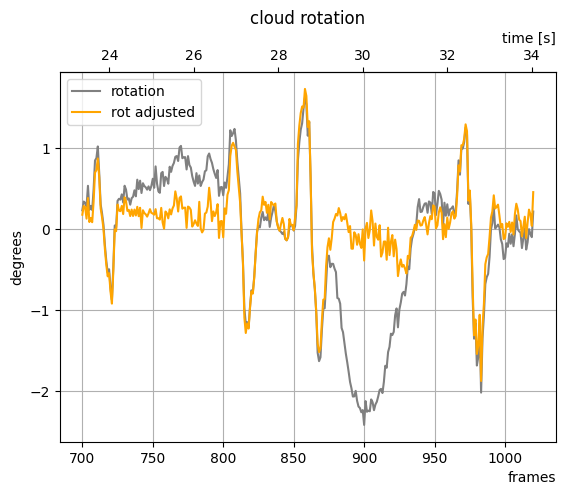

CPU times: total: 2.14 s
Wall time: 2.19 s


In [7]:
from ipywidgets import interact
import ipywidgets as widgets

@interact
def run_interact(fd_from = widgets.IntSlider(description = 'diff from:', min=2, max=12, value=6),
        fd_to = widgets.IntSlider(description = 'diff to:', min=4, max=14, value=10) ):
    run_and_plot_all(fd_from, fd_to)

#run_and_plot_all(6, 10)    # plot without widgets as a workaround for Github/VS Code issues